<a href="https://colab.research.google.com/github/devipriyaraju/NLP_Image_Captioning_Project/blob/main/Modified_Inceptionv3_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from keras.layers import Input,Activation,MaxPooling2D,AveragePooling2D, concatenate, GlobalAveragePooling2D,Conv2D, BatchNormalization
from keras.backend import image_data_format
from keras.applications.inception_v3 import preprocess_input
import numpy as np
from keras import layers
from keras.applications.imagenet_utils import decode_predictions
import keras.backend as K
import imutils
from keras.models import Model
from keras.utils import get_file
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
os.chdir("/content/gdrive/MyDrive/Colab Notebooks")
from google.colab import files


WEIGHTS_PATH = (
    'https://github.com/fchollet/deep-learning-models/'
    'releases/download/v0.5/'
    'inception_v3_weights_tf_dim_ordering_tf_kernels.h5')
WEIGHTS_PATH_NO_TOP = (
    'https://github.com/fchollet/deep-learning-models/'
    'releases/download/v0.5/'
    'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

img_input=Input(shape=(224,224,3))
channel_axis=3

Mounted at /content/gdrive


In [2]:
def conv2D_bn(x,filters,nrow,ncol,padding='same',strides=(1,1)):
  x=Conv2D(filters,(nrow,ncol),strides=strides,padding=padding)(x)
  x=BatchNormalization(axis=3, scale=False)(x)
  x=Activation('relu')(x)
  return x


Inception Module

In [3]:
def InceptionModuleA(x,f1,f2,f3):  #Naive Version
  conv1 =Conv2D(f1, (1,1), padding= "same", activation="relu")(x)
  conv3 =Conv2D(f2,(3,3),padding="same", activation="relu")(x)
  conv5=Conv2D(f3(5,5), padding='same',activation='relu')(x)
  pooling = MaxPooling2D((3,3), strides=(1,1), padding="same")(x)
  out=concatenate([conv1,conv3,conv5,pooling])
  return out


In [4]:
def modified_inception_a(x):
  layer1_1 = conv2D_bn(x,64,1,1)
  layer5_5 = conv2D_bn(x,48,1,1)
  layer3_3 = conv2D_bn(x,64,1,1)
  pool1 = AveragePooling2D((3,3), strides =(1,1), padding = "same")(x)
  pool2 = conv2D_bn(pool1, 32,1,1)
  x= layers.concatenate([layer1_1,layer5_5,layer3_3,pool2], axis= channel_axis)
  return x

In [5]:
def modified_inception_b(x):
  layer1_10 = conv2D_bn(x,192,1,1)

  layer7_7 = conv2D_bn(x,128,1,1)
  layer7_7 = conv2D_bn(layer7_7, 128,1,7)
  layer7_7 = conv2D_bn(layer7_7, 192,7,1)

  layer1_1 = conv2D_bn(x, 128,1,1)
  layer1_1 = conv2D_bn(layer1_1,128,7,1)
  layer1_1 = conv2D_bn(layer1_1,128,1,7)
  layer1_1 = conv2D_bn(layer1_1,128,7,1)
  layer1_1 = conv2D_bn(layer1_1,128,1,7)

  pool1 = layers.AveragePooling2D((3,3), strides= (1,1), padding = "same")(x)
  pool1 = conv2D_bn(pool1,192,1,1)
  x = layers.concatenate([layer1_10, layer7_7, layer1_1,pool1], axis=channel_axis)
  return x
  

In [6]:
def modified_inception_c(x):
  layer1_1 = conv2D_bn(x,320,1,1)

  layer3_3 = conv2D_bn(x,384,1,1)
  layer3_1 = conv2D_bn(layer3_3, 384,1,3)
  layer3_2 = conv2D_bn(layer3_3,384,3,1)
  layer3 = layers.concatenate([layer3_1, layer3_2], axis = channel_axis)

  layer11 = conv2D_bn(x,448,1,1)
  layer11 = conv2D_bn(layer11,384,3,3)
  layer11_1 = conv2D_bn(layer11,384,1,3) 
  layer11_2 = conv2D_bn(layer11, 384,3,1)
  layer11 = layers.concatenate([layer11_1,layer11_2], axis =channel_axis)

  pool1 = layers.AveragePooling2D((3,3), strides = (1,1), padding="same")(x)
  pool = conv2D_bn(pool1, 192,1,1)
  x= layers.concatenate([layer1_1,layer3,layer11, pool], axis=channel_axis)
  return x

In [7]:
def reduce_inception_a(x):
  layer3_31 = conv2D_bn(x,384,3,3,strides = (2,2), padding= "valid")

  layer3_3 = conv2D_bn(x,64,1,1)
  layer3_3 = conv2D_bn(layer3_3,96,3,3)
  layer3_3 = conv2D_bn(layer3_3,96,3,3,strides = (2,2), padding="valid")
  pool1 = layers.MaxPooling2D((3,3), strides = (2,2))(x)
  x = layers.concatenate([layer3_31, layer3_3, pool1], axis=channel_axis)
  return x



In [8]:
def reduce_inception_b(x):
  layer3_3 = conv2D_bn(x,192,1,1)
  layer3_3 = conv2D_bn(layer3_3, 320,3,3, strides=(2,2), padding="valid")

  layer7_3 = conv2D_bn(x,192,1,1)
  layer7_3 = conv2D_bn(layer7_3,192,1,7)
  layer7_3 = conv2D_bn(layer7_3, 192,7,1)
  layer7_3 = conv2D_bn(layer7_3, 192,3,3, strides=(2,2), padding="valid")

  pool1 = layers.MaxPooling2D((3,3), strides = (2,2))(x)
  x= layers.concatenate([layer3_3, layer7_3, pool1], axis=channel_axis)
  return x

Building Layers:

In [9]:
x = conv2D_bn(img_input, 32,3,3, strides=(2,2), padding="valid")
x = conv2D_bn(x,32,3,3,padding="valid")
x = conv2D_bn(x,64,3,3)
x = layers.MaxPooling2D((3,3),strides=(2,2))(x)
x = conv2D_bn(x,80,1,1,padding="valid")
x = conv2D_bn(x,192,3,3,padding="valid")
x = layers.MaxPooling2D((3,3),strides=(2,2))(x)


x = modified_inception_a(x)
x = modified_inception_a(x)
x = modified_inception_a(x)
x = reduce_inception_a(x)

x = modified_inception_b(x)
x = modified_inception_b(x)
x = modified_inception_b(x)
x = modified_inception_b(x) 

x = reduce_inception_b(x)

x = modified_inception_c(x)
x = modified_inception_c(x)

x = layers.GlobalAveragePooling2D(name = "avg_pool")(x)
#x = layers.Dense(classes, activation="softmax", name="predictions")(x)
from keras.models import Model
from keras import models
#Create Model
inputs = img_input
model = models.Model(inputs,x,name='modified_inception')

model.summary()


Model: "modified_inception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                

In [10]:
model.save('Modified_incpetionv3')

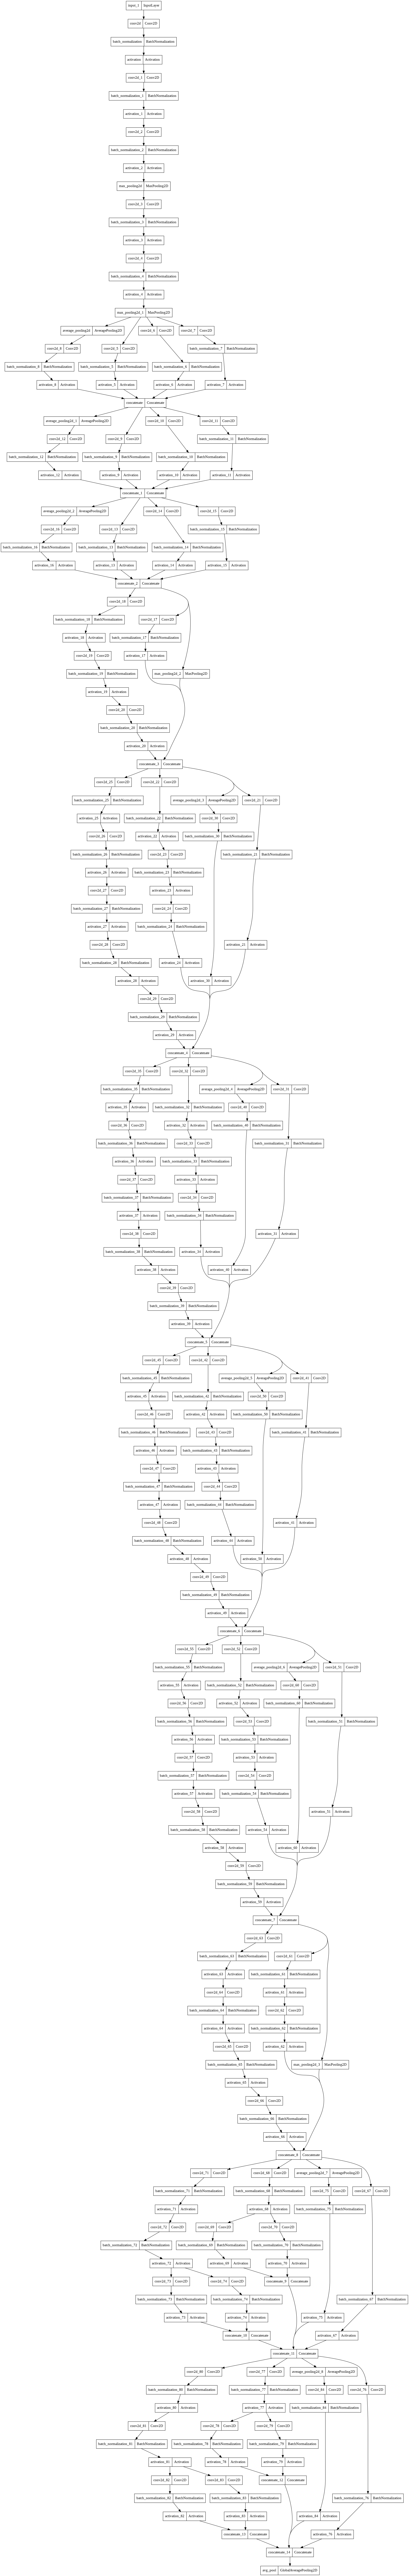

In [17]:

import keras
from keras.utils import plot_model
re = keras.models.load_model("Modified_incpetionv3")
plot_model(re, to_file='model.png')